In [277]:
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or 'retina'
%matplotlib inline

sns.set(context='notebook', style='whitegrid')

from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score,\
                            f1_score,precision_recall_fscore_support, log_loss, precision_recall_curve,\
                            fbeta_score, roc_curve
import xgboost as xgb

In [2]:
profile_df = pd.read_csv('./data/profile_df.csv', index_col=0)
profile_df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [3]:
del profile_df['CITY']

In [233]:
# Create df with only utilized input features

feature_df = profile_df.loc[:, 'Income':'CURRENT_HOUSE_YRS']

In [5]:
# Add dummy variables to df

feature_plus_dummies = pd.get_dummies(feature_df, drop_first=True)

In [6]:
feature_plus_dummies

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Married/Single_single,House_Ownership_owned,House_Ownership_rented,Car_Ownership_yes,Profession_Analyst,...,STATE_Punjab,STATE_Rajasthan,STATE_Sikkim,STATE_Tamil_Nadu,STATE_Telangana,STATE_Tripura,STATE_Uttar_Pradesh,STATE_Uttar_Pradesh[5],STATE_Uttarakhand,STATE_West_Bengal
0,1303834,23,3,3,13,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7574516,40,10,9,13,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3991815,66,4,4,10,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6256451,41,2,2,12,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5768871,47,11,3,14,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251995,8154883,43,13,6,11,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
251996,2843572,26,10,6,11,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
251997,4522448,46,7,7,12,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
251998,6507128,45,0,0,10,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Make dataframe with quantitative columns only for standardizing

quant_features = feature_plus_dummies[['Income','Age','Experience','CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS' ]]
quant_features

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
0,1303834,23,3,3,13
1,7574516,40,10,9,13
2,3991815,66,4,4,10
3,6256451,41,2,2,12
4,5768871,47,11,3,14
...,...,...,...,...,...
251995,8154883,43,13,6,11
251996,2843572,26,10,6,11
251997,4522448,46,7,7,12
251998,6507128,45,0,0,10


In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
# Standardize quantitative columns

std = StandardScaler()

X = std.fit_transform(quant_features)

In [11]:
quant_features_std = pd.DataFrame(X)

In [12]:
quant_features_std.columns = quant_features.columns

In [13]:
quant_features_std

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
0,-1.283145,-1.579604,-1.180232,-0.914131,0.716356
1,0.895457,-0.583344,-0.014067,0.731036,0.716356
2,-0.349269,0.940348,-1.013637,-0.639936,-1.427981
3,0.437526,-0.524740,-1.346827,-1.188325,0.001577
4,0.268128,-0.173119,0.152528,-0.914131,1.431135
...,...,...,...,...,...
251995,1.097092,-0.407533,0.485719,-0.091547,-0.713202
251996,-0.748199,-1.403793,-0.014067,-0.091547,-0.713202
251997,-0.164913,-0.231723,-0.513852,0.182647,0.001577
251998,0.524618,-0.290326,-1.680018,-1.736714,-1.427981


In [14]:
# Create df of only dummy variables

dummy_features_only = feature_plus_dummies.loc[:,'Married/Single_single': 'STATE_West_Bengal']

In [15]:
#Merge standardized data set with dummy variable data set

fully_converted_df = quant_features_std.join(dummy_features_only)

In [235]:
fully_converted_df.head()

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Married/Single_single,House_Ownership_owned,House_Ownership_rented,Car_Ownership_yes,Profession_Analyst,...,STATE_Punjab,STATE_Rajasthan,STATE_Sikkim,STATE_Tamil_Nadu,STATE_Telangana,STATE_Tripura,STATE_Uttar_Pradesh,STATE_Uttar_Pradesh[5],STATE_Uttarakhand,STATE_West_Bengal
0,-1.283145,-1.579604,-1.180232,-0.914131,0.716356,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.895457,-0.583344,-0.014067,0.731036,0.716356,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.349269,0.940348,-1.013637,-0.639936,-1.427981,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.437526,-0.524740,-1.346827,-1.188325,0.001577,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.268128,-0.173119,0.152528,-0.914131,1.431135,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [16]:
fully_converted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 87 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Income                                 252000 non-null  float64
 1   Age                                    252000 non-null  float64
 2   Experience                             252000 non-null  float64
 3   CURRENT_JOB_YRS                        252000 non-null  float64
 4   CURRENT_HOUSE_YRS                      252000 non-null  float64
 5   Married/Single_single                  252000 non-null  uint8  
 6   House_Ownership_owned                  252000 non-null  uint8  
 7   House_Ownership_rented                 252000 non-null  uint8  
 8   Car_Ownership_yes                      252000 non-null  uint8  
 9   Profession_Analyst                     252000 non-null  uint8  
 10  Profession_Architect                   252000 non-null  

In [17]:
# split data into train & test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(fully_converted_df, profile_df['Risk_Flag'], test_size=0.20, random_state=42)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(201600, 87)
(50400, 87)
(201600,)
(50400,)


In [121]:
# baseline probability


y_train.mean()

0.12273313492063492

# K-Nearest Neighbors 

#### Baseline KNN(Model 1) - DONE

In [19]:
# Instantiate KNN Model and fit training data
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(class_weight = 'balanced', n_neighbors=50)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=50)

In [220]:
# Make predictions with model
from sklearn import metrics
y_pred = knn.predict(X_test)



In [256]:
# Output Metrics

print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('f2_score:', fbeta_score(y_test, y_pred, beta=2))
print('ROC_AUC Score', roc_auc_score(y_test, knn.predict_proba(X_test)[:,1]))
print('log_loss:', log_loss(y_test, knn.predict_proba(X_test)[:,1]))

Accuracy: 0.8792857142857143
Recall: 0.11818327202942587
Precision: 0.5645530939648586
F1 Score: 0.19545093890505152
f2_score: 0.14038220432354392
ROC_AUC Score 0.8558192310063244
log_loss: 0.412716430515697


#### KNN Grid Search Baseline(model 2)  RERUN WITH F1

In [21]:
from sklearn.model_selection import GridSearchCV

In [455]:
# define the parameter(k) values that will be searched
# since 250k observations, will look at k values in increments of 100

k_range = list(range(1,2002,100))

param_grid = dict(n_neighbors=k_range)

In [456]:
f_b_scorer_1 = make_scorer(fbeta_score, beta=3)

In [457]:
# Instantiate grid

grid = GridSearchCV(knn, param_grid, cv=10, scoring=f_b_scorer_1)

In [458]:
#train model with best parameter

grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_neighbors=50),
             param_grid={'n_neighbors': [1, 101, 201, 301, 401, 501, 601, 701,
                                         801, 901, 1001, 1101, 1201, 1301, 1401,
                                         1501, 1601, 1701, 1801, 1901, 2001]},
             scoring=make_scorer(fbeta_score, beta=3))

In [459]:
df_cv = pd.DataFrame(grid.cv_results_)
df_cv.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.134402,0.078466,41.112312,0.538739,1,{'n_neighbors': 1},0.493219,0.485827,0.459396,0.471149,0.482641,0.469810,0.454379,0.464539,0.474586,0.468312,0.472386,0.011419,1
1,0.111801,0.005527,62.921663,2.330403,101,{'n_neighbors': 101},0.024574,0.028168,0.020133,0.027272,0.029067,0.024152,0.019704,0.019689,0.021018,0.020134,0.023391,0.003553,2
2,0.122331,0.009132,64.914099,2.381320,201,{'n_neighbors': 201},0.000000,0.000000,0.000000,0.000000,0.000000,0.000449,0.000000,0.000000,0.000000,0.000000,0.000045,0.000135,3
3,0.114086,0.005383,64.455425,2.458351,301,{'n_neighbors': 301},0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
4,0.113272,0.007574,65.409020,2.220786,401,{'n_neighbors': 401},0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4


In [460]:
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

Best params:  {'n_neighbors': 1}
Best estimator:  KNeighborsClassifier(n_neighbors=1)
Best score:  0.4723856380072496


Text(80.90000000000006, 0.5, 'Actual')

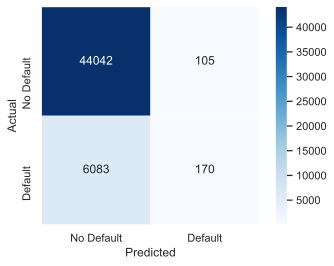

In [461]:
from sklearn.metrics import confusion_matrix

knn_confusion = confusion_matrix(y_test, y_grid_pred)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
# plt.title('Logistic regression confusion matrix');

#plt.savefig("confusion_matrix_logit")

In [462]:
# Make predictions with best parameter
# Grid Search automatically refits model with best parameter

y_grid_pred = grid.predict(X_test)

In [463]:
print('Accuracy:', metrics.accuracy_score(y_test, y_grid_pred))
print('Precision:', precision_score(y_test, y_grid_pred))
print('Recall:', recall_score(y_test, y_grid_pred))
print('F1 Score:', f1_score(y_test, y_grid_pred))
print('f2_score:', fbeta_score(y_test, y_grid_pred, beta = 3))
print('ROC_AUC Score', roc_auc_score(y_test, knn.predict_proba(X_test)[:,1]))
print('log_loss:', log_loss(y_test, knn.predict_proba(X_test)[:,1]))

Accuracy: 0.875515873015873
Precision: 0.49824150058616645
Recall: 0.47577162961778346
F1 Score: 0.48674738219895286
f2_score: 0.4779270016707364
ROC_AUC Score 0.8558192310063244
log_loss: 0.412716430515697


# Logistic Regression

#### Baseline Logistic Regression(Model 3) - DONE

In [38]:
from sklearn.linear_model import LogisticRegression

In [122]:
# Instantiate and fit model
# Find accuracy scores for training and test data

logit = LogisticRegression(class_weight='balanced', C = 0.95, max_iter = 2000)
logit.fit(X_train, y_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_test, y_test)))

The score for logistic regression is
Training:  54.63%
Test set:  54.22%


In [123]:
# make predictions with baseline Logistic model

y_logit_pred = logit.predict(X_test)

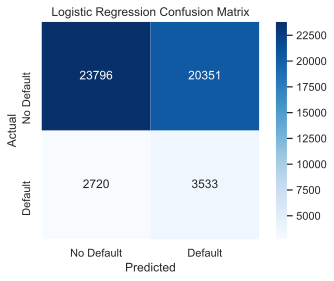

In [188]:
# Create a "confusion matrix" within context of a heatmap

from sklearn.metrics import confusion_matrix

logit_confusion = confusion_matrix(y_test, y_logit_pred)
sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
            xticklabels=['No Default', 'Default'],
          yticklabels=['No Default', 'Default'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix');

#plt.savefig("confusion_matrix_logit")

In [243]:
# Output Metrics

print('Accuracy:', accuracy_score(y_test, y_logit_pred))
print('Precision:',precision_score(y_test, y_logit_pred, zero_division=1))
print('Recall:',recall_score(y_test, y_logit_pred))
print('f1_score:', f1_score(y_test, y_logit_pred))
print('f2_score:', fbeta_score(y_test, y_logit_pred, beta=2))
print('roc_auc_score:', roc_auc_score(y_test, logit.predict_proba(X_test)[:,1]))
print('log_loss:', log_loss(y_test, logit.predict_proba(X_test)[:,1]))

Accuracy: 0.5422420634920635
Precision: 0.14792329593032993
Recall: 0.5650087957780265
f1_score: 0.2344626206988088
f2_score: 0.36127699607329844
roc_auc_score: 0.5762145452942458
log_loss: 0.6841254007483655


#### Baseline Logistic Regression Grid Search(Model 4) - Run Another model with f weighted score

In [213]:
# Set parameters to optimize

param_grid = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1500, 2000, 2500, 3000], 'max_iter': list(range(1500,5000,250))}]

In [215]:
logit_grid = GridSearchCV(logit, param_grid, cv=10, scoring = 'f1')

logit_grid

GridSearchCV(cv=10,
             estimator=LogisticRegression(C=0.95, class_weight='balanced',
                                          max_iter=2000),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1500, 2000,
                                2500, 3000],
                          'max_iter': [1500, 1750, 2000, 2250, 2500, 2750, 3000,
                                       3250, 3500, 3750, 4000, 4250, 4500,
                                       4750]}],
             scoring='f1')

In [216]:
logit_grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(C=0.95, class_weight='balanced',
                                          max_iter=2000),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1500, 2000,
                                2500, 3000],
                          'max_iter': [1500, 1750, 2000, 2250, 2500, 2750, 3000,
                                       3250, 3500, 3750, 4000, 4250, 4500,
                                       4750]}],
             scoring='f1')

In [217]:
print("Best params: ", logit_grid.best_params_)
print("Best estimator: ", logit_grid.best_estimator_)
print("Best score: ", logit_grid.best_score_)

Best params:  {'C': 1500, 'max_iter': 1500}
Best estimator:  LogisticRegression(C=1500, class_weight='balanced', max_iter=1500)
Best score:  0.23229519158738351


In [218]:
grid_logit_pred = logit_grid.predict(X_test)

In [251]:
print('Accuracy:', accuracy_score(y_test, grid_logit_pred))
print('Precision:',precision_score(y_test, grid_logit_pred, zero_division=1))
print('Recall:',recall_score(y_test, grid_logit_pred))
print('f1_score:', f1_score(y_test, grid_logit_pred))
print('f2_score:', fbeta_score(y_test, grid_logit_pred, beta=3))
print('ROC_AUC Score:',roc_auc_score(y_test, logit_grid.predict_proba(X_test)[:,1]))
print('log_loss:', log_loss(y_test, logit_grid.predict_proba(X_test)[:,1]))

Accuracy: 0.5421626984126984
Precision: 0.14786904462865277
Recall: 0.5648488725411802
f1_score: 0.23438070274395303
f2_score: 0.44060227286902937
ROC_AUC Score: 0.576220214532601
log_loss: 0.6841320992544656


# Decision Tree

In [82]:
from sklearn.tree import DecisionTreeClassifier

In [201]:
dec_tree = DecisionTreeClassifier(class_weight='balanced',max_depth=4)

dec_tree.fit(X_train, y_train)

dec_tree.score(X_test, y_test)

0.32341269841269843

In [202]:
dec_tree_pred = dec_tree.predict(X_test)

In [248]:
print('Accuracy:', accuracy_score(y_test, dec_tree_pred))
print('Precision:', precision_score(y_test, dec_tree_pred))
print('Recall:', recall_score(y_test,dec_tree_pred))
print('F1 Score:', f1_score(y_test, dec_tree_pred))
print('f2_score:', fbeta_score(y_test, dec_tree_pred, beta=3))
print('roc_auc_score:', roc_auc_score(y_test, dec_tree.predict_proba(X_test)[:,1]))
print('log_loss:', log_loss(y_test, dec_tree.predict_proba(X_test)[:,1]))

Accuracy: 0.32341269841269843
Precision: 0.13247987330077868
Recall: 0.8026547257316488
F1 Score: 0.22742308215143414
f2_score: 0.5330175654722712
roc_auc_score: 0.5489321109286576
log_loss: 0.6853819085783436


# Random Forest

In [85]:
from sklearn.ensemble import RandomForestClassifier

In [206]:
rand_forest  = RandomForestClassifier(class_weight = 'balanced', n_estimators=100)

rand_forest.fit(X_train, y_train)

rand_forest.score(X_test, y_test)



0.8956944444444445

In [207]:
rand_forest_pred = rand_forest.predict(X_test)

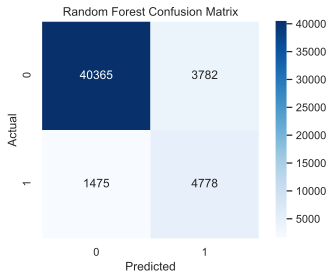

In [211]:
rand_forest_confusion = confusion_matrix(y_test, rand_forest_pred)
sns.heatmap(rand_forest_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')
#            xticklabels=profile_df[['No Default', 'Default']],
#            yticklabels=profile_df[['No Default', 'Default']])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix');

#plt.savefig("confusion_matrix_logit")

In [267]:
print('Accuracy:', accuracy_score(y_test, rand_forest_pred))
print('Precision:', precision_score(y_test, rand_forest_pred))
print('Recall:', recall_score(y_test, rand_forest_pred))
print('F1 Score:', f1_score(y_test, rand_forest_pred))
print('f2_score:', fbeta_score(y_test, rand_forest_pred, beta = 3))
print('roc_auc_score:', roc_auc_score(y_test, rand_forest.predict_proba(X_test)[:,1]))
print('log_loss:', log_loss(y_test, rand_forest.predict_proba(X_test)[:,1]))

Accuracy: 0.8956944444444445
Precision: 0.5581775700934579
Recall: 0.7641132256516872
F1 Score: 0.6451090258556673
f2_score: 0.7369249039900057
roc_auc_score: 0.9381846137370948
log_loss: 0.2504906321721783


In [ ]:
# from sklearn.metrics import make_scorer, fbeta_score
# from sklearn.model_selection import GridSearchCV

# f_b_scorer = make_scorer(fbeta_score, beta=.3)
# cv = GridSearchCV(estimator, params, scoring=f_b_scorer)

#### Random Forest Grid Search

In [341]:
from sklearn.metrics import make_scorer, fbeta_score

In [342]:
f_b_scorer = make_scorer(fbeta_score, beta=3)

In [343]:

n_estimators = list(range(100,501,100)) 
num_split_features = list(range(int(np.sqrt(87)-5), int(np.sqrt(87)+6)))

param_grid = dict(n_estimators = n_estimators, max_features=num_split_features)


In [344]:
rf_grid = GridSearchCV(rand_forest, param_grid, cv=10, scoring = f_b_scorer)

In [345]:
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_features': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring=make_scorer(fbeta_score, beta=3))

In [346]:
print("Best params: ", rf_grid.best_params_)
print("Best estimator: ", rf_grid.best_estimator_)
print("Best score: ", rf_grid.best_score_)

Best params:  {'max_features': 4, 'n_estimators': 100}
Best estimator:  RandomForestClassifier(class_weight='balanced', max_features=4)
Best score:  0.7385160339063261


In [347]:
rf_grid_pred = rf_grid.predict(X_test)

In [348]:
print('f2_score:', fbeta_score(y_test, rf_grid_pred, beta = 3))

f2_score: 0.737337136689538


In [378]:
rf_feature_importance = rand_forest.feature_importances_

In [424]:
sorted_rf_feature_importance = sorted(rf_feature_importance, reverse=True)[:5]

In [425]:
sorted_rf_feature_importance

[0.16156068130839926,
 0.1320814257522902,
 0.08629287511215905,
 0.07896896895023603,
 0.06545089569972284]

In [426]:
indexes = np.argsort(sorted_rf_feature_importance)
rf_columns = X_train.columns

In [427]:
indexes

array([4, 3, 2, 1, 0])

In [428]:
columns = X_train.columns

([<matplotlib.axis.YTick at 0x7fa0062d6a60>,
 [Text(0, 0, 'CURRENT_HOUSE_YRS'),
  Text(0, 1, 'CURRENT_JOB_YRS'),
  Text(0, 2, 'Experience'),
  Text(0, 3, 'Age'),
  Text(0, 4, 'Income')])

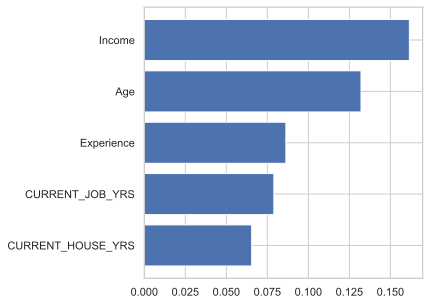

In [433]:
plt.figure(figsize=(5,5))

plt.barh(range(len(indexes)), rf_feature_importance[indexes])
plt.yticks(range(len(indexes)), [columns[c] for c in indexes])



#### XG Boost

In [278]:
X_train_xgb, X_val, y_train_xgb, y_val = train_test_split(X_train, y_train, test_size =0.20, random_state = 42)

In [448]:
# Model 1

#ratio = (y_train_xgb ==0).sum()/(y_train_xgb==1).sum()

gbm_1 = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=3,
                        objective='binary:logistic', #new objective
                        learning_rate=.0001, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        scale_pos_weight = 7 
                       )

In [438]:
gbm_1.best_ntree_limit

3

In [439]:
gbm_1.evals_result_

{'validation_0': OrderedDict([('error',
               [0.700285,
                0.315371,
                0.304836,
                0.360522,
                0.359139,
                0.362909,
                0.347892,
                0.344841,
                0.346106,
                0.339131,
                0.33662,
                0.337444,
                0.336942,
                0.332664,
                0.336186,
                0.333569,
                0.334828,
                0.332961,
                0.331783,
                0.334555,
                0.328844,
                0.329774,
                0.333228,
                0.333904,
                0.332112,
                0.329607,
                0.3328,
                0.333829,
                0.333755,
                0.335144,
                0.333495,
                0.332006,
                0.330928,
                0.3313,
                0.330264,
                0.330289,
                0.33205,
    

In [449]:
eval_set=[(X_train_xgb.values ,y_train_xgb.values),(X_val.values,y_val.values)]
fit_model = gbm_1.fit( 
                    X_train_xgb.values, y_train_xgb.values, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=10,
                    verbose=True
                   )

/Users/rahulraju/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-error:0.21346	validation_1-error:0.21577
[1]	validation_0-error:0.21346	validation_1-error:0.21577
[2]	validation_0-error:0.20598	validation_1-error:0.20831
[3]	validation_0-error:0.28302	validation_1-error:0.28118
[4]	validation_0-error:0.28834	validation_1-error:0.28668
[5]	validation_0-error:0.28834	validation_1-error:0.28668
[6]	validation_0-error:0.30350	validation_1-error:0.30164
[7]	validation_0-error:0.30364	validation_1-error:0.30191
[8]	validation_0-error:0.30117	validation_1-error:0.29948
[9]	validation_0-error:0.28643	validation_1-error:0.28512
[10]	validation_0-error:0.30198	validation_1-error:0.29953
[11]	validation_0-error:0.30247	validation_1-error:0.29993
[12]	validation_0-error:0.30281	validation_1-error:0.30040


In [450]:
gbm_1.predict(X_test)

/Users/rahulraju/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


array([0, 1, 0, ..., 1, 0, 0])

''

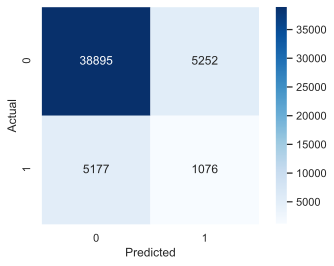

In [451]:
rand_forest_confusion = confusion_matrix(y_test, gbm_1.predict(X_test))
sns.heatmap(rand_forest_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')
#            xticklabels=profile_df[['No Default', 'Default']],
#            yticklabels=profile_df[['No Default', 'Default']])

plt.xlabel('Predicted')
plt.ylabel('Actual')
;

#plt.savefig("confusion_matrix_logit")

In [436]:
accuracy_score(y_test, gbm_1.predict(X_test, ntree_limit=gbm_1.best_ntree_limit))

/Users/rahulraju/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/rahulraju/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.6934722222222223

In [437]:
fbeta_score(y_train, gbm_1.predict(X_train, ntree_limit=gbm_1.best_ntree_limit), beta = 2)

/Users/rahulraju/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/rahulraju/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.2860768743923844

In [307]:
# Model 2

#ratio = (y_train_xgb ==0).sum()/(y_train_xgb==1).sum()

gbm_1 = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        scale_pos_weight = ratio)

                       

In [308]:
eval_set=[(X_train_xgb.values ,y_train_xgb.values),(X_val.values,y_val.values)]
fit_model = gbm_1.fit( 
                    X_train_xgb.values, y_train_xgb.values, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

/Users/rahulraju/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [309]:
fbeta_score(y_test, gbm_1.predict(X_test, ntree_limit=gbm_1.best_ntree_limit), beta = 3)

/Users/rahulraju/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/rahulraju/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.31903803036145273

In [310]:
fbeta_score(y_test, gbm_1.predict(X_test, ntree_limit=gbm_1.best_ntree_limit), beta = 3)

/Users/rahulraju/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/rahulraju/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.31903803036145273